In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [2]:
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error

/Users/apple/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
transaction = pd.read_csv('transactions_sampled.csv',
                         names = ['id','chain','dept','category','company',
                                 'brand','date','productsize','productmeasure',
                                 'purchasequantity','purchaseamount'])

In [4]:
transaction['date'] = transaction['date'].apply(lambda x: pd.to_datetime(x))

In [5]:
transaction.head()

,id,chain,dept,category,company,brand,date,productsize,productmeasure,purchasequantity,purchaseamount
0,696521494,211,55,5558,101111010,9907,2013-01-23,36.0,OZ,1,2.99
1,417112954,100,63,6320,107509070,182,2012-12-09,12.0,CT,1,2.29
2,308340717,360,35,3504,103500030,13470,2012-06-12,10.0,OZ,1,1.79
3,4629335121,153,63,6320,1068826767,81691,2012-09-10,12.0,CT,1,2.79
4,743051948,58,63,6330,101111010,9907,2012-10-07,16.0,OZ,1,2.79


In [6]:
def missing_count(dataset):
    missing = {}
    for col in dataset.columns:
        missing[col] = len(dataset[dataset[col].isnull()])
    return missing

In [7]:
missing_count(transaction)

{'brand': 0,
 'category': 0,
 'chain': 0,
 'company': 0,
 'date': 0,
 'dept': 0,
 'id': 0,
 'productmeasure': 16260,
 'productsize': 0,
 'purchaseamount': 0,
 'purchasequantity': 0}

In [8]:
len(set(transaction['chain']))   # 132 chain stores

132

In [9]:
len(transaction.groupby(['category','company','brand','productsize','productmeasure']).purchaseamount.sum())
# 60443 different types of goods

60443

In [10]:
len(set(transaction['id']))  #204078 different customers

204078

In [11]:
transaction.shape[0]   #500,000 transactions

500000

In [12]:
len(set(transaction['category']))   #806 categories

806

In [13]:
len(set(transaction['company']))   #9867 transactions

9867

### This shows all records with null measurement of product are associated with 0.0 product size, which indicates either product returns or changes. I then fill all the null values of product measure with 'Unknown'.

In [14]:
transaction['productmeasure'].value_counts()

OZ    407541
CT     60347
RL      6270
LB      5667
LT      3736
YD       176
FT         2
1          1
Name: productmeasure, dtype: int64

In [15]:
transaction.loc[transaction[transaction['productmeasure'] == '1'].index, 'productmeasure'] = 'OZ'

In [16]:
transaction['productmeasure'].fillna('Unknown', inplace = True)

### I also add a feature 'price' indicating the price of the product in the transaction, which is calculated as amount purchased in the transaction divided by quantity purchased in the transaction. For returns or changes, I just fill the price with zero.

In [17]:
transaction['price'] = transaction.apply(lambda x: x.purchaseamount/x.purchasequantity if (x.purchaseamount>0 and x.purchasequantity > 0 ) else 0, axis = 1)

In [18]:
len(transaction[(transaction['purchaseamount'] <= 0) | (transaction['purchasequantity'] <= 0)])

19360

In [19]:
len(transaction)

500000

### This shows out of 500,000 transactions there are 19,360 transactions are either returns or changes, which counts for 3.872% of the total transactions.

In [20]:
transaction['price'].describe()

count    500000.000000
mean          3.364557
std           4.893497
min           0.000000
25%           1.666667
50%           2.690000
75%           3.990000
max        1623.550000
Name: price, dtype: float64

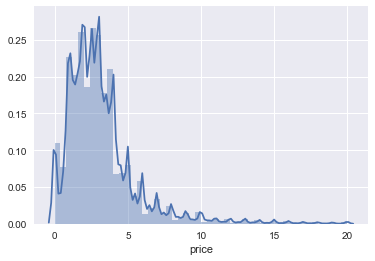

In [21]:
sns.distplot(transaction[transaction['price'] < 20].price)   

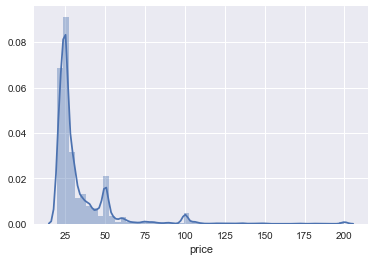

In [22]:
sns.distplot(transaction[(transaction['price'] >= 20) & (transaction['price'] <= 200)].price)

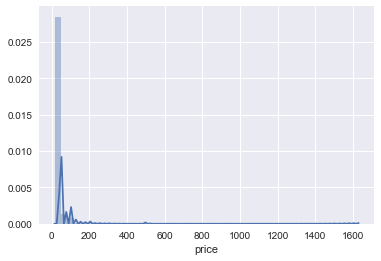

In [23]:
sns.distplot(transaction[transaction['price'] >= 20].price)

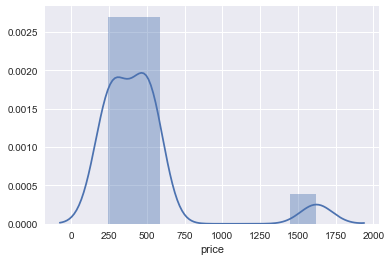

In [24]:
sns.distplot(transaction[transaction['price'] > 200].price)

### Take a look at quantity purchased in the transaction.

In [25]:
transaction['purchasequantity'].describe()

count    500000.000000
mean          1.603382
std           6.372761
min         -33.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        1742.000000
Name: purchasequantity, dtype: float64

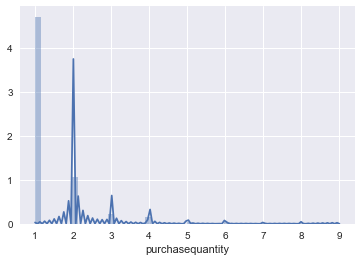

In [26]:
sns.distplot(transaction[(transaction['purchasequantity'] < 10) & (transaction['purchasequantity'] > 0)].purchasequantity)   ## an important graph showing the majority of price distribution

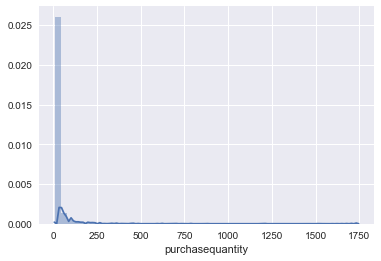

In [27]:
sns.distplot(transaction[transaction['purchasequantity'] >= 10].purchasequantity)   ## an important graph showing the majority of price distribution

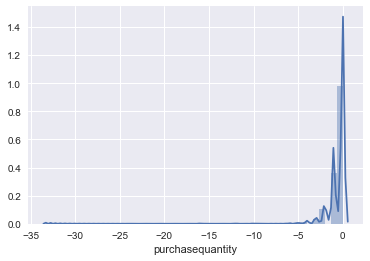

In [28]:
sns.distplot(transaction[transaction['purchasequantity'] <= 0].purchasequantity)   ## an important graph showing the majority of price distribution

### I now extract year and month information from the data.

In [37]:
transaction['year'] = transaction['date'].dt.year
transaction['month'] = transaction['date'].dt.month

### I want to build date block for each transaction, that is, transactions in the same month will be grouped in the same date block. For example,  transactions in March 2012 belongs to date block 'lag_16',  transactions in April 2012 belongs to date block'lag_15',..., transactions in July 2013 belongs to date block'lag_0'.

In [38]:
transaction['dateblock'] = transaction.apply(lambda x: "lag_{}".format(2020-(x.year+x.month)) if x.year == 2013 else "lag_{}".format(2031-(x.year + x.month)), axis = 1)

In [39]:
chain_transaction_counts = pd.DataFrame({'Count': transaction['dateblock'].value_counts().sort_values(ascending = False)})

In [40]:
chain_transaction_counts= chain_transaction_counts.reindex_axis([u'lag_0', u'lag_1', u'lag_2', u'lag_3', u'lag_4', u'lag_5',
       u'lag_6', u'lag_7', u'lag_8', u'lag_9', u'lag_10', u'lag_11', u'lag_12',
       u'lag_13', u'lag_14', u'lag_15', u'lag_16'], axis = 0)

Text(0.5,1,u'Number of transaction in each dateblock/month')

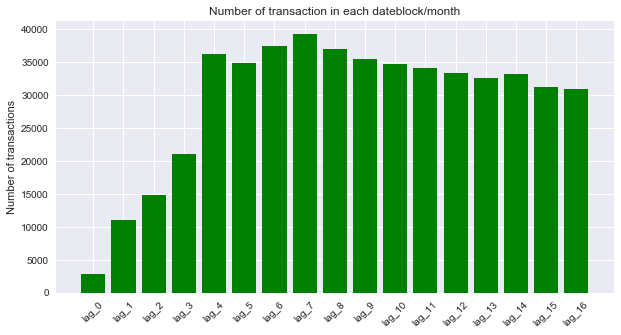

In [41]:
plt.figure(figsize = (10, 5))
plt.bar(np.arange(len(chain_transaction_counts)), chain_transaction_counts.Count, color = 'green')
plt.xticks(np.arange(len(chain_transaction_counts)), chain_transaction_counts.index, rotation = 45)
plt.ylabel("Number of transactions")
plt.title("Number of transaction in each dateblock/month")

### It seems since April 2013 (corresponding to dateblock 'lag_3','lag_2','lag_1','lag_0'), the number of transactions decreased significantly and is not in the same pattern as previous months. Is this because transaction data are missing in these four months or just because number of transactions become much fewer than before? 

In [42]:
ave_quantity_block = transaction.groupby(['dateblock']).purchasequantity.mean()
ave_amount_block = transaction.groupby(['dateblock']).purchaseamount.mean()

In [43]:
ave_quantity_block= ave_quantity_block.reindex_axis([u'lag_0', u'lag_1', u'lag_2', u'lag_3', u'lag_4', u'lag_5',
       u'lag_6', u'lag_7', u'lag_8', u'lag_9', u'lag_10', u'lag_11', u'lag_12',
       u'lag_13', u'lag_14', u'lag_15', u'lag_16'], axis = 0)

In [44]:
ave_amount_block= ave_amount_block.reindex_axis([u'lag_0', u'lag_1', u'lag_2', u'lag_3', u'lag_4', u'lag_5',
       u'lag_6', u'lag_7', u'lag_8', u'lag_9', u'lag_10', u'lag_11', u'lag_12',
       u'lag_13', u'lag_14', u'lag_15', u'lag_16'], axis = 0)

Text(0.5,1,u'Average quantity purchased per transaction')

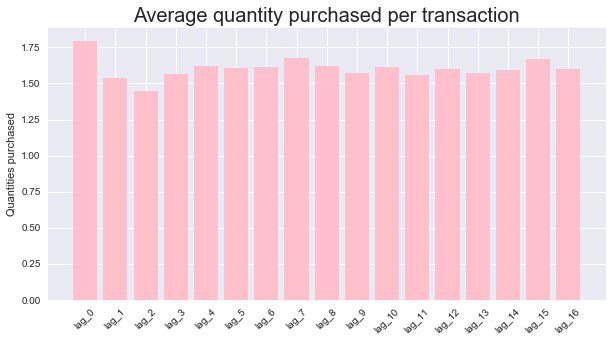

In [45]:
plt.figure(figsize = (10, 5))
plt.bar(np.arange(len(ave_quantity_block)),ave_quantity_block.values, color = 'pink')
plt.xticks(np.arange(len(ave_quantity_block)),ave_quantity_block.index, rotation = 45)
plt.ylabel('Quantities purchased')
plt.title('Average quantity purchased per transaction', fontsize = 20)

Text(0.5,1,u'Average amount purchased per transaction')

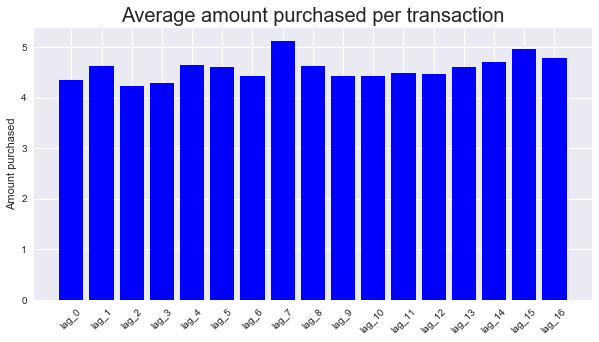

In [46]:
plt.figure(figsize = (10, 5))
plt.bar(np.arange(len(ave_amount_block)),ave_amount_block.values, color = 'blue')
plt.xticks(np.arange(len(ave_amount_block)),ave_amount_block.index, rotation = 45)
plt.ylabel('Amount purchased')
plt.title('Average amount purchased per transaction', fontsize = 20)

In [47]:
total_quantity_block = transaction.groupby(['dateblock']).purchasequantity.sum()
total_amount_block = transaction.groupby(['dateblock']).purchaseamount.sum()

In [48]:
total_quantity_block= total_quantity_block.reindex_axis([u'lag_0', u'lag_1', u'lag_2', u'lag_3', u'lag_4', u'lag_5',
       u'lag_6', u'lag_7', u'lag_8', u'lag_9', u'lag_10', u'lag_11', u'lag_12',
       u'lag_13', u'lag_14', u'lag_15', u'lag_16'], axis = 0)

In [49]:
total_amount_block= total_amount_block.reindex_axis([u'lag_0', u'lag_1', u'lag_2', u'lag_3', u'lag_4', u'lag_5',
       u'lag_6', u'lag_7', u'lag_8', u'lag_9', u'lag_10', u'lag_11', u'lag_12',
       u'lag_13', u'lag_14', u'lag_15', u'lag_16'], axis = 0)

Text(0.5,1,u'Total quantity purchased each month')

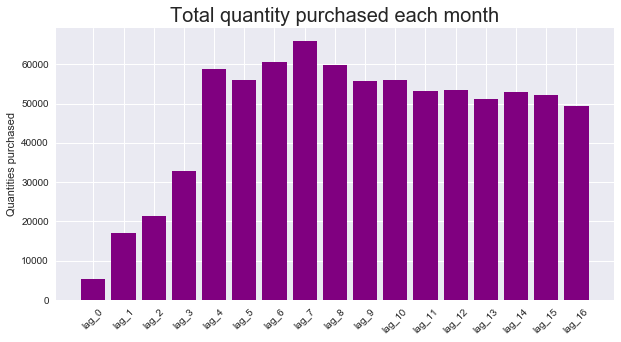

In [50]:
plt.figure(figsize = (10, 5))
plt.bar(np.arange(len(total_quantity_block)),total_quantity_block.values, color = 'purple')
plt.xticks(np.arange(len(total_quantity_block)),total_quantity_block.index, rotation = 45)
plt.ylabel('Quantities purchased')
plt.title('Total quantity purchased each month', fontsize = 20)

Text(0.5,1,u'Total amount purchased each month')

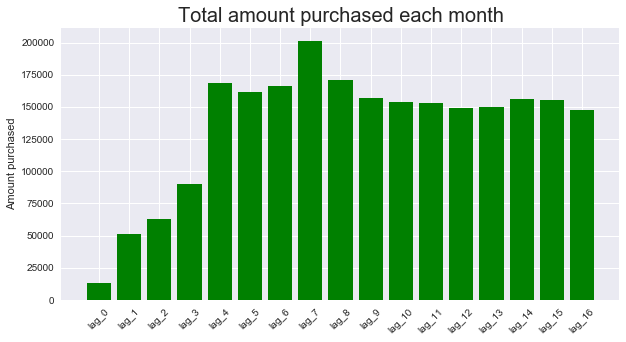

In [51]:
plt.figure(figsize = (10, 5))
plt.bar(np.arange(len(total_amount_block)),total_amount_block.values, color = 'green')
plt.xticks(np.arange(len(total_amount_block)),total_amount_block.index, rotation = 45)
plt.ylabel('Amount purchased')
plt.title('Total amount purchased each month', fontsize = 20)

### Average purchase per transaction looks simialr across all months, but total purchases per months are different, 'lag_0','lag_1','lag_2','lag_3' are especially small compared with the rest. We examine the transaction numbers in each selected popular store across all months.

In [52]:
popular_chains = [21,96,214,101,31,360,89,191,152,101,46,153,360]

In [53]:
transaction_pop_chains = transaction[transaction['chain'].isin(popular_chains)]

In [54]:
transaction_pop_chains.reset_index(drop = True)

,id,chain,dept,category,company,brand,date,productsize,productmeasure,purchasequantity,purchaseamount,price,year,month,dateblock
0,308340717,360,35,3504,103500030,13470,2012-06-12,10.00,OZ,1,1.79,1.790000,2012,6,lag_13
1,4629335121,153,63,6320,1068826767,81691,2012-09-10,12.00,CT,1,2.79,2.790000,2012,9,lag_10
2,4235139153,214,4,410,101420010,3294,2012-10-02,1.12,OZ,11,3.63,0.330000,2012,10,lag_9
3,2739666735,46,63,6305,104850040,18799,2012-03-20,59.00,OZ,1,3.19,3.190000,2012,3,lag_16
4,496271276,21,27,2705,107910070,85,2012-07-25,22.00,OZ,4,7.08,1.770000,2012,7,lag_12
5,501103393,21,26,2632,1085502282,12632,2012-12-22,80.00,CT,3,2.97,0.990000,2012,12,lag_7
6,477462045,101,59,5902,1068826767,81691,2013-01-24,16.00,OZ,1,2.79,2.790000,2013,1,lag_6
7,2406744864,214,41,4121,104122040,23511,2012-06-11,8.00,OZ,3,1.00,0.333333,2012,6,lag_13
8,3378435506,214,41,4107,103710030,10383,2013-03-17,14.75,OZ,2,1.30,0.650000,2013,3,lag_4
9,3693848948,214,67,6708,105080353,19537,2012-08-23,1.00,CT,1,14.98,14.980000,2012,8,lag_11


In [55]:
transaction_pop_chains['count'] = pd.DataFrame(np.array([1]*len(transaction_pop_chains)))

/Users/apple/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [56]:
transaction_by_chains = transaction_pop_chains.pivot_table('count', aggfunc = 'count',
                                                          index = 'dateblock',
                                                          columns = 'chain')

In [57]:
price_by_chains = transaction_pop_chains.pivot_table('price', aggfunc = 'mean',
                                                          index = 'dateblock',
                                                          columns = 'chain')

In [58]:
transaction_by_chains.reindex_axis([u'lag_0', u'lag_1', u'lag_2', u'lag_3', u'lag_4', u'lag_5',
       u'lag_6', u'lag_7', u'lag_8', u'lag_9', u'lag_10', u'lag_11', u'lag_12',
       u'lag_13', u'lag_14', u'lag_15', u'lag_16'], axis = 0)

chain,21,31,46,89,96,101,152,153,191,214,360
dateblock,,,,,,,,,,,
lag_0,38,150,58,37,27,53,15,35,37,23,22
lag_1,151,241,257,125,159,270,50,129,144,155,81
lag_2,233,262,263,170,226,327,68,184,195,211,107
lag_3,805,297,275,231,366,369,165,260,207,368,197
lag_4,1623,393,490,394,673,612,640,498,287,551,398
lag_5,1797,305,510,366,612,552,596,454,243,669,334
lag_6,1991,344,488,424,741,601,626,512,264,672,377
lag_7,2099,292,525,456,741,664,620,504,334,599,460
lag_8,1946,262,539,377,711,574,554,414,276,689,409


In [59]:
price_by_chains.reindex_axis([u'lag_0', u'lag_1', u'lag_2', u'lag_3', u'lag_4', u'lag_5',
       u'lag_6', u'lag_7', u'lag_8', u'lag_9', u'lag_10', u'lag_11', u'lag_12',
       u'lag_13', u'lag_14', u'lag_15', u'lag_16'], axis = 0)

chain,21,31,46,89,96,101,152,153,191,214,360
dateblock,,,,,,,,,,,
lag_0,2.493938,3.315193,2.948482,2.547670,2.761686,2.537183,3.988974,3.292233,2.830104,2.523729,3.701232
lag_1,3.053956,3.583176,3.227065,3.163597,3.023986,2.877906,3.581956,3.512103,3.487630,3.557038,3.850710
lag_2,3.126012,3.780433,3.198675,2.901500,3.029138,3.036910,3.802561,3.426764,3.444721,3.279545,4.074850
lag_3,3.056283,4.478373,2.992777,2.856867,3.491399,2.789427,3.578495,3.472194,3.039533,2.799960,3.585917
lag_4,3.116217,4.069383,3.148497,2.676751,3.620299,2.843694,3.706581,3.571558,3.075059,3.144046,3.666687
lag_5,3.070746,4.116680,2.999074,2.681915,3.498450,2.885144,3.752374,3.741619,3.361630,3.172890,3.608180
lag_6,3.010690,3.919461,3.076548,2.734667,3.146185,2.793783,3.749404,3.567613,3.364193,3.087047,3.471743
lag_7,3.204570,4.235238,3.311579,3.056667,4.173254,3.249746,3.974577,3.618819,3.654693,2.988584,3.671475
lag_8,3.056687,4.075343,3.553216,2.566056,4.247083,2.830767,3.844803,3.477840,3.922469,2.955003,3.903194


Text(0.5,1,u'Number of transactions by month for each store')

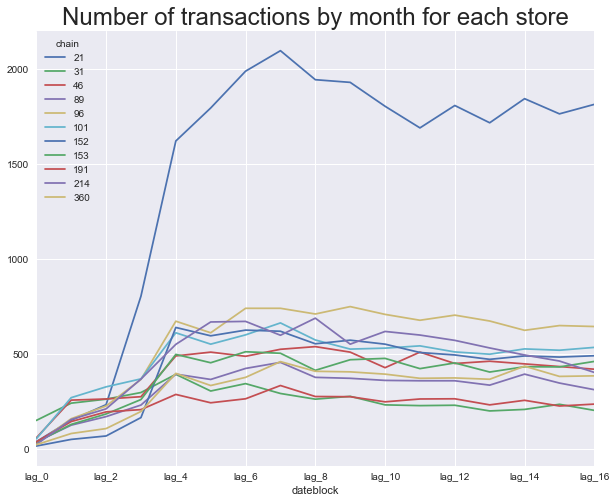

In [60]:
ax = transaction_by_chains.reindex_axis([u'lag_0', u'lag_1', u'lag_2', u'lag_3', u'lag_4', u'lag_5',
       u'lag_6', u'lag_7', u'lag_8', u'lag_9', u'lag_10', u'lag_11', u'lag_12',
       u'lag_13', u'lag_14', u'lag_15', u'lag_16'], axis = 0).plot(figsize = (10, 8))
ax.set_title("Number of transactions by month for each store", fontsize = 24)

Text(0.5,1,u'Average price by month for each store')

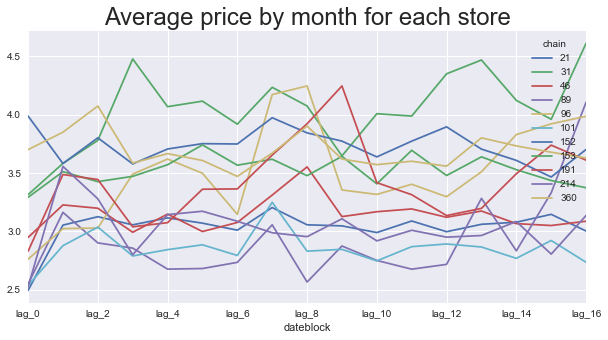

In [61]:
ax = price_by_chains.reindex_axis([u'lag_0', u'lag_1', u'lag_2', u'lag_3', u'lag_4', u'lag_5',
       u'lag_6', u'lag_7', u'lag_8', u'lag_9', u'lag_10', u'lag_11', u'lag_12',
       u'lag_13', u'lag_14', u'lag_15', u'lag_16'], axis = 0).plot(figsize = (10, 5))
ax.set_title("Average price by month for each store", fontsize = 24)

### I see that the average amount and average quantity purchased per transaction are not significantly different across all months, so the shopping behavior of customers are normal. After checking transactions per store in selected date blocks, I conclude there are large number of missing records on transactions from each store in the latest four months in the dataset.

### Hence in building models of demand forecasting, I will just throw away data in datablock 'lag_0','lag_1','lag_2','lag_3', and buidling models on the transaction data from March 2012 to March 2013, supposed i want to predict what happens in April 2013.

## Demand Forcasting of each item for each store

In [62]:
date_block_deserted = ['lag_0','lag_1','lag_2','lag_3']

In [63]:
data = transaction[~transaction['dateblock'].isin(date_block_deserted)]

In [64]:
data.head()

,id,chain,dept,category,company,brand,date,productsize,productmeasure,purchasequantity,purchaseamount,price,year,month,dateblock
0,696521494,211,55,5558,101111010,9907,2013-01-23,36.0,OZ,1,2.99,2.99,2013,1,lag_6
1,417112954,100,63,6320,107509070,182,2012-12-09,12.0,CT,1,2.29,2.29,2012,12,lag_7
2,308340717,360,35,3504,103500030,13470,2012-06-12,10.0,OZ,1,1.79,1.79,2012,6,lag_13
3,4629335121,153,63,6320,1068826767,81691,2012-09-10,12.0,CT,1,2.79,2.79,2012,9,lag_10
4,743051948,58,63,6330,101111010,9907,2012-10-07,16.0,OZ,1,2.79,2.79,2012,10,lag_9


In [65]:
data_quantity_table = data.pivot_table(index = ['chain','company','brand','category','productsize','productmeasure'],
                             columns ='dateblock',
                             values = 'purchasequantity',
                              aggfunc = 'sum').fillna(0).reset_index()

In [66]:
features = ['chain',
 'company',
 'brand',
 'category',
 'productsize',
 'productmeasure',
 'lag_16',
 'lag_15',
 'lag_14',
 'lag_13',
 'lag_12',
 'lag_11',
 'lag_10',
 'lag_9',
 'lag_8',
 'lag_7',
 'lag_6',
 'lag_5',
 'lag_4']

In [67]:
data_quantity_table = data_quantity_table[features]

In [68]:
data_quantity_table = data_quantity_table.rename(columns = {'lag_4': 'lag_0_q',
                                             'lag_5': 'lag_1_q',
                                             'lag_6': 'lag_2_q',
                                             'lag_7': 'lag_3_q',
                                             'lag_8': 'lag_4_q',
                                             'lag_9': 'lag_5_q',
                                             'lag_10': 'lag_6_q',
                                             'lag_11': 'lag_7_q',
                                             'lag_12': 'lag_8_q',
                                             'lag_13': 'lag_9_q',
                                             'lag_14': 'lag_10_q',
                                             'lag_15': 'lag_11_q',
                                             'lag_16': 'lag_12_q'})

In [69]:
data_quantity_table.head()  #'dateblock' is not a feature.

dateblock,chain,company,brand,category,productsize,productmeasure,lag_12_q,lag_11_q,lag_10_q,lag_9_q,lag_8_q,lag_7_q,lag_6_q,lag_5_q,lag_4_q,lag_3_q,lag_2_q,lag_1_q,lag_0_q
0,2,10000,0,0,0.0,Unknown,1.0,1.0,25.0,15.0,34.0,15.0,25.0,26.0,23.0,39.0,12.0,21.0,32.0
1,2,10000,0,9753,1.0,CT,0.0,5.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,0.0,2.0
2,2,10000,20405,0,0.0,Unknown,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3,2,1013313,52604,1841,1.0,CT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2,10100010,9907,1006,16.0,OZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [70]:
#encode label to 'productmeasure'
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data_quantity_table['productmeasure'] = le.fit_transform(data_quantity_table['productmeasure'])

In [71]:
outlier_num_sum = 0
for i in range(12):
    outlier_num_sum += len(data_quantity_table[data_quantity_table['lag_{}_q'.format(i+1)]>10])
outlier_num_ave = outlier_num_sum / 12
outlier_num_ave 

347

In [72]:
outlier_num_sum_2 = 0
for i in range(12):
    outlier_num_sum_2 += len(data_quantity_table[data_quantity_table['lag_{}_q'.format(i+1)]<0])
outlier_num_ave_2 = outlier_num_sum_2 / 12
outlier_num_ave_2 

14

In [73]:
outlier_num_sum_3 = 0
for i in range(12):
    outlier_num_sum_3 += len(data_quantity_table[data_quantity_table['lag_{}_q'.format(i+1)]>5])
outlier_num_ave_3 = outlier_num_sum_3 / 12
outlier_num_ave_3 

1091

In [74]:
outlier_num_sum_4 = 0
for i in range(12):
    outlier_num_sum_4 += len(data_quantity_table[data_quantity_table['lag_{}_q'.format(i+1)]>3])
outlier_num_ave_4 = outlier_num_sum_4 / 12
outlier_num_ave_4 

2433

In [75]:
float(outlier_num_ave+outlier_num_ave_2)/len(data_quantity_table)

0.0016302678877869903

In [76]:
float(outlier_num_ave_3+outlier_num_ave_2)/len(data_quantity_table)

0.004990155168987879

In [77]:
float(outlier_num_ave_4+outlier_num_ave_2)/len(data_quantity_table)

0.011050597012229267

### This shows around 0.16%, 0.50%, 1.1% of the total products on average each month have total purchase quantity greater than 10 or fewer than 0,  greater than 5 or fewer than 0, greater than 3 or fewer than 0.

### To eliminate noise, we only consider products with nonnegative total purchase quantity fewer or equal to 5  in the most recent month ( the month before the month we want to predict).

In [78]:
data_q_table = data_quantity_table[(data_quantity_table['lag_1_q'] <= 5) &(data_quantity_table['lag_1_q'] >= 0) ]

### Building models to forecast demand. Split data into training data and validation data.

In [79]:
X_q = data_q_table.iloc[:,:-1].values
y_q = data_q_table.iloc[:,-1].values

In [80]:
X_q_train, X_q_test, y_q_train,y_q_test = train_test_split(X_q, y_q, test_size = 0.2, random_state = 42)

In [81]:
# Train the data
rf_q = RandomForestRegressor(n_estimators=10, 
                           max_depth= 50, random_state=42)
rf_q.fit(X_q_train, y_q_train)
y_q_pred_train = rf_q.predict(X_q_train)
rf_q_mse_train = mean_squared_error(y_q_pred_train, y_q_train)
print("Train-data_quantity RMSE", np.sqrt(rf_q_mse_train))  ##2.3446132369561439

('Train-data_quantity RMSE', 2.3446132369561439)


In [82]:
# Validate the data
y_q_pred_validate = rf_q.predict(X_q_test)

In [83]:
rf_q_mse_validate = mean_squared_error(y_q_pred_validate, y_q_test)
print("Validation-data_quantity RMSE", np.sqrt(rf_q_mse_validate))  
##1.6523771650705217

('Validation-data_quantity RMSE', 1.6523771650705217)


In [85]:
import xgboost as xgb

In [86]:
xgb_q_1 = xgb.XGBRegressor(objective = 'reg:linear',
                        max_depth = 12,
                        subsample = 0.9,
                        colsample_bytree = 0.9,
                        min_child_weight = 0.5,
                        learning_rate = 0.1,
                        seed = 0,
                        silent = 0
                        )

In [87]:
# Train the data
xgb_q_1.fit(X_q_train, y_q_train)
y_q_pred_train_2 = xgb_q_1.predict(X_q_train)
xgb_q_mse_train_2 = mean_squared_error(y_q_pred_train_2, y_q_train)
print("Train-data_quantity RMSE", np.sqrt(xgb_q_mse_train_2))  
#1.1356049609028387

('Train-data_quantity RMSE', 1.1356049609028387)


In [88]:
# Validate the data
y_q_pred_validate_2 = xgb_q_1.predict(X_q_test)
xgb_q_mse_validate_2 = mean_squared_error(y_q_pred_validate_2, y_q_test)
print("Validation-data_quantity RMSE", np.sqrt(xgb_q_mse_validate_2))  
# 1.5709862566678292

('Validation-data_quantity RMSE', 1.5709862566678292)


In [91]:
#xgb_q = xgb.XGBRegressor(objective = 'reg:linear',
   #                     max_depth = 12,
     #                   subsample = 1,
       #                 min_child_weight = 0.5,
        #                learning_rate = 0.3,
                     
              #          seed = 0,
                #        silent = 0
                #        )

In [92]:
# Train the data
#xgb_q.fit(X_q_train, y_q_train)
#y_q_pred_train_2 = xgb_q.predict(X_q_train)
#xgb_q_mse_train_2 = mean_squared_error(y_q_pred_train_2, y_q_train)
#print("Train-data_quantity RMSE", np.sqrt(xgb_q_mse_train_2))  
#1.9777077582810094, 0.29823162339574755, 0.36379839594639068, ||0.36780988264979808

In [93]:
# Validate the data
#y_q_pred_validate_2 = xgb_q.predict(X_q_test)
#xgb_q_mse_validate_2 = mean_squared_error(y_q_pred_validate_2, y_q_test)
#print("Validation-data_quantity RMSE", np.sqrt(xgb_q_mse_validate_2))  
# 8.5485484180593012, 0.63565184832549237,3.6811122625121593, ||1.8510391535923996

In [ ]:
### Grid Search with xgboost 

In [ ]:
#parameters = {
 #   'learning_rate': [0.05,0.1, 0.4],
  #  'max_depth': [12,20,50]
    #'min_child_weight': [0.5, 1],
   # 'subsample':[0.9,1],
   # 'colsample_bytree': [0.9,1]
#    }

In [ ]:
#xgb_grid = GridSearchCV(xgb_q_1, parameters, cv = 3)

In [ ]:
#xgb_grid.fit(X_q_train, y_q_train) 

In [ ]:
#print xgb_grid.best_score_

In [ ]:
#print xgb_grid.best_params_

In [ ]:
#xgb_q_2 = xgb.XGBRegressor(objective = 'reg:linear',
     #                   max_depth = 12,
      #                  subsample = 1,
       #                 min_child_weight = 0.5,
         #               learning_rate = 0.1,
                     
            #            seed = 0,
            #            silent = 0
             #           )